# Testing low rank and sparse PFM

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from low_rank_pfm.src.low_rank import low_rank
from low_rank_pfm.src.hrf_matrix import HRFMatrix
from low_rank_pfm.low_rank_pfm import debiasing
from simulate import fMRIsim

## Simulate data

In [2]:
# Initialize class
sim = fMRIsim()

# Set parameters
sim.nvoxels = 1000
sim.nevents = 4
sim.min_length = 1 # Minimun TR length of an event
sim.max_length = 5 # Maximum TR length of an event
sim.gap = 35 # Number of timepoints between events
sim.tr = 2
sim.dur = 600 # In seconds
sim.te = [35] # Must be a list
sim.db = 20
sim.ngroups = 5
sim.group = [20, 30, 15, 35, 900] # Must be a list

# Simulate timeseries
sim.simulate()


Groups: [20, 30, 15, 35, 900]
Group change idxs: [  0.  19.  49.  64.  99. 999.]
Finishing simulation of data...


In [3]:
data = sim.simulation
ground_truth = sim.bold
nscans = data.shape[0]
nvoxels = data.shape[1]
print(f'Data has {nscans} scans and {nvoxels} voxels')

Data has 300 scans and 1000 voxels


## Plot data without spikes and respiration

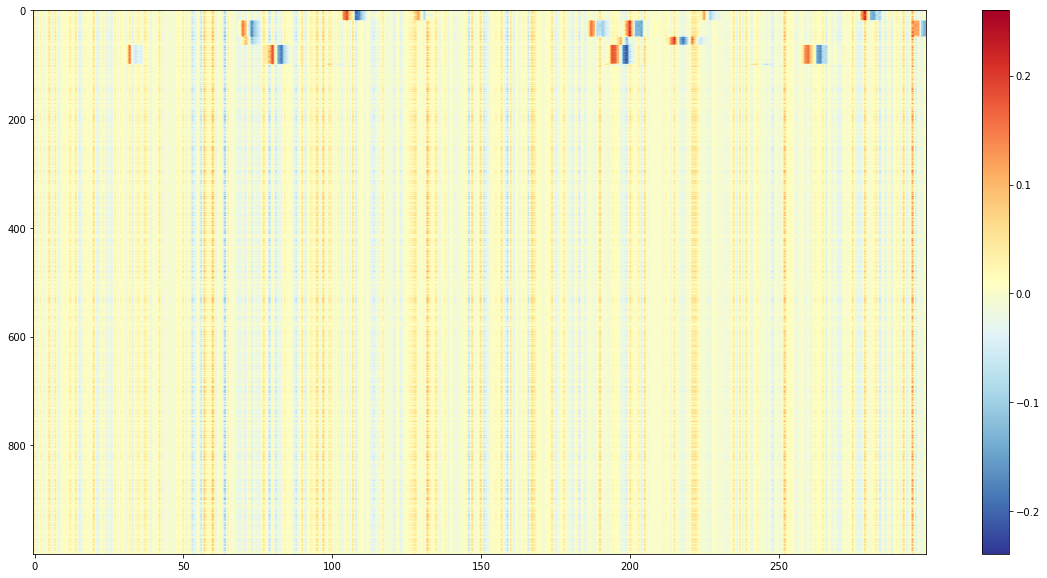

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(data.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()

## Add respiration and spikes

In [5]:
t = np.linspace(0, nscans * sim.tr, nscans)
RRF = 0.6 * (t ** 2.1) * np.exp(-t/1.6) - 0.0023 * (t ** 3.54) * np.exp(-t/4.25)

RRF_mtx = RRF
for i in range(nscans-1):
    foo = np.append(np.zeros(i+1), RRF[0:(len(RRF)-i-1)])      
    RRF_mtx = np.column_stack((RRF_mtx, foo))

resp_spikes = np.zeros((nscans, 1))
resp_spikes[50] = 1
resp_spikes[150] = 1
resp_spikes_conv = np.dot(RRF_mtx, resp_spikes)
resp_spikes_conv = resp_spikes_conv/np.max(resp_spikes_conv)*np.max(data[:])*0.8

spikes_scale = np.random.rand(nvoxels)
spikes = np.dot(resp_spikes_conv, np.ones((1, nvoxels))) * spikes_scale

data += spikes

## Plot data with spikes and respiration

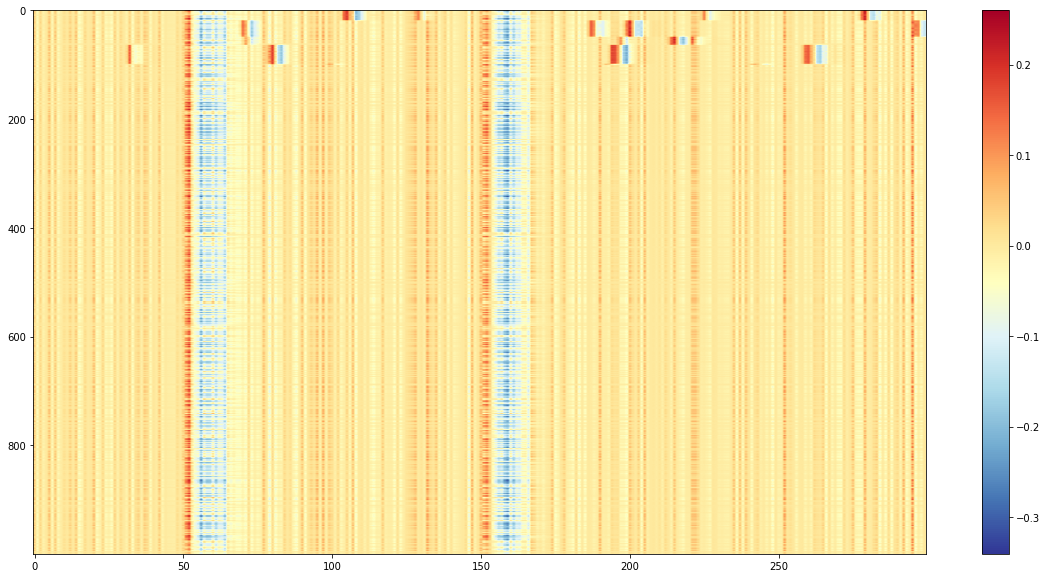

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(data.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()

## Low rank and sparse PFM

In [7]:
%%capture
hrf_obj = HRFMatrix(TR=sim.tr, nscans=int(data.shape[0]), TE=sim.te)
hrf_norm = hrf_obj.generate_hrf().X_hrf_norm

L, S = low_rank(data=data, hrf=hrf_norm, proximal='sparse', rho=0.8)

# Debiasing
S_deb, S_fitts = debiasing(x=hrf_norm, y=data, beta=S)

## Plot results

Text(0.5, 1.0, 'Estimated fitts')

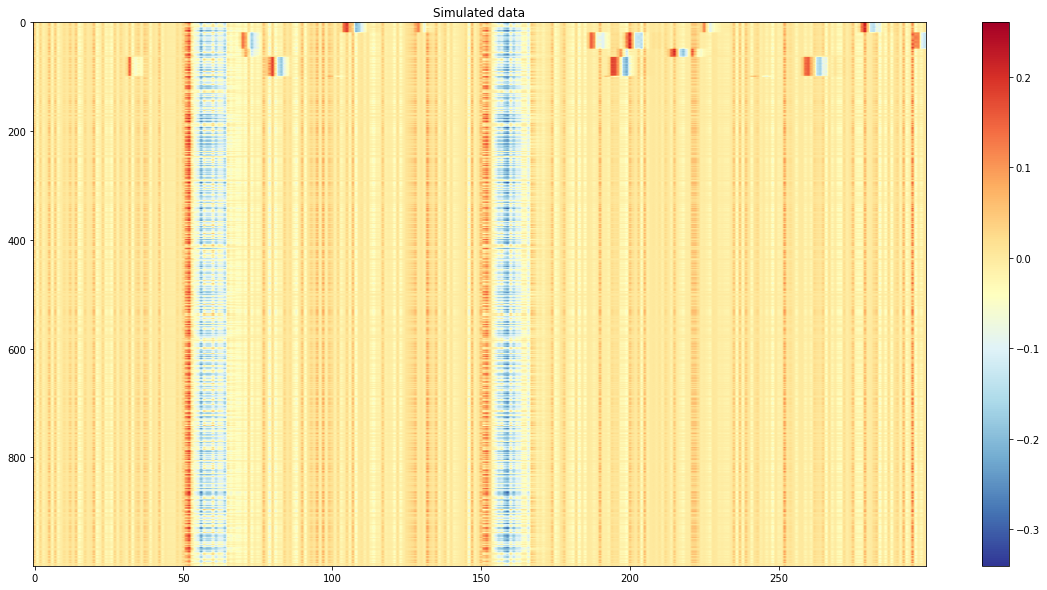

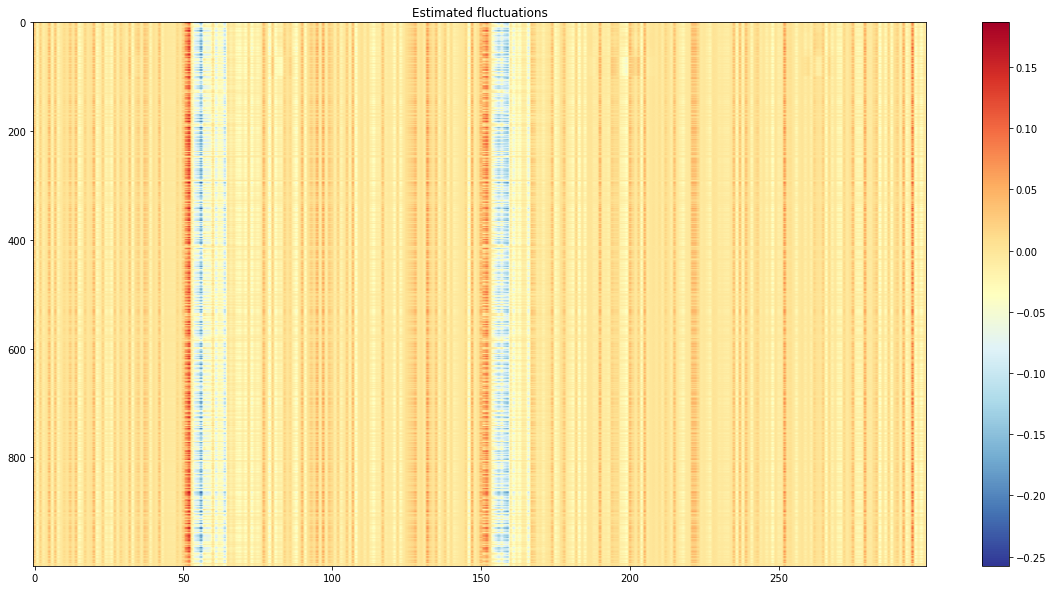

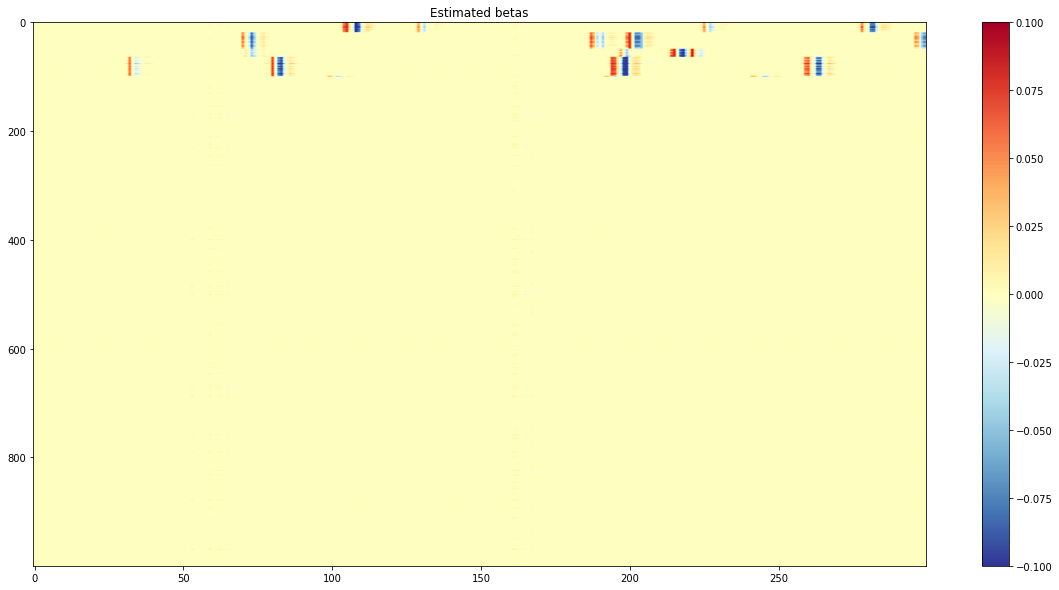

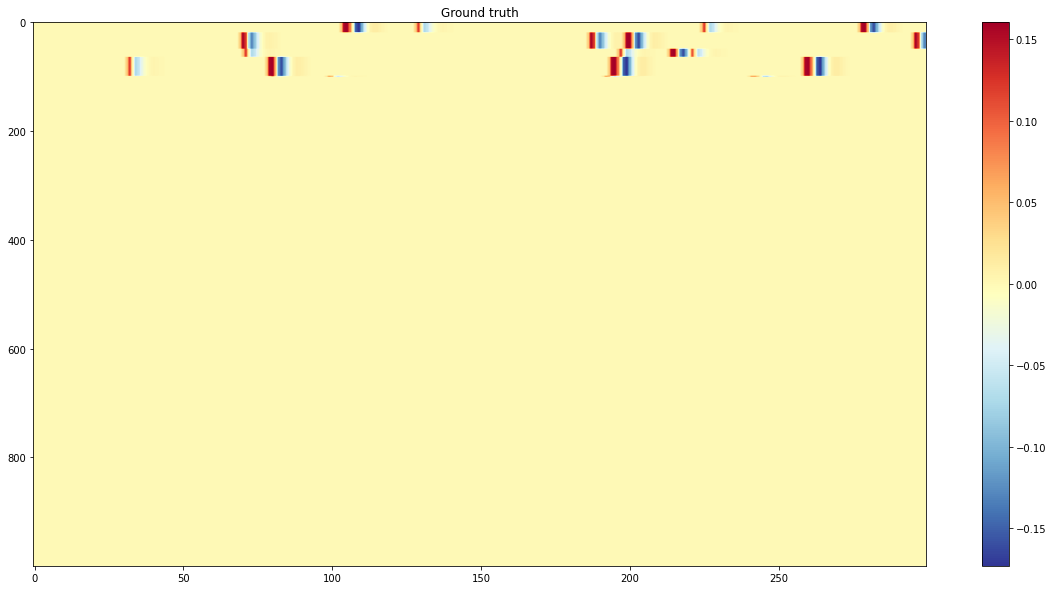

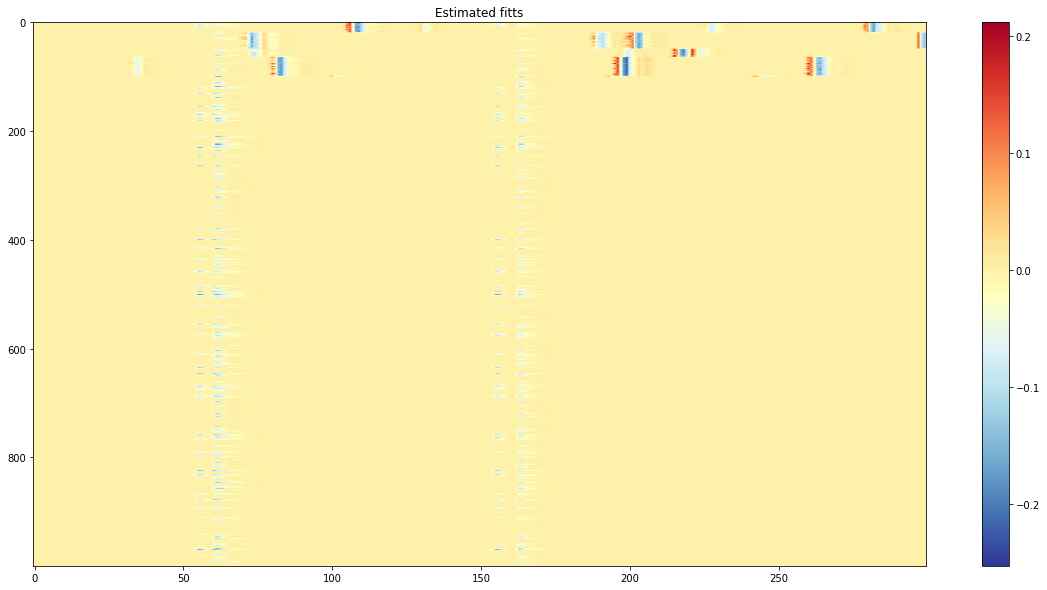

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(data.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Simulated data')

plt.figure(figsize=(20,10))
plt.imshow(L.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Estimated fluctuations')

plt.figure(figsize=(20,10))
plt.imshow(S.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title('Estimated betas')

plt.figure(figsize=(20,10))
plt.imshow(ground_truth.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Ground truth')

plt.figure(figsize=(20,10))
plt.imshow(S_fitts.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Estimated fitts')

In [14]:
np.unique(np.where(abs(S) > 10 * 1e-3))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 131, 132, 133, 135, 136, 137, 138, 139,
       140, 141, 160, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173,
       201, 202, 203, 204, 205, 206, 208, 209, 210, 212, 223, 229, 230,
       232, 235, 237, 238, 239, 241, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 255, 256, 257, 279, 280, 281, 282, 284, 28